<a href="https://colab.research.google.com/github/dudabattaglia/MVPMachineLearn-Analytics/blob/main/MVP_ML_%26_Analytics_Maria_Eduarda_PUC_RIO_finalv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP: Machine Learning & Analytics

**Autor:** Maria Eduarda Battaglia Pedreira Fernandes

**Sprint:** MACHINE LEARNING & ANALYTICS  

**Data:** 24/09/2025

**Matrícula:** 4052024002108

**Dataset:** [Kaggle — Spotify Tracks Dataset](https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset?resource=download) (URL raw do GitHub utilizada para reprodutibilidade).



# Introdução
- Contextualização: previsão da popularidade de faixas usando dados acústicos e metadados.
- Motivação: entender fatores que explicam a popularidade e criar modelo preditivo.
- Objetivo: desenvolver modelo de regressão que minimize RMSE em conjunto de teste.



#Contexto de Negócio
- Empresas de streaming precisam prever popularidade para recomendar músicas e alocar marketing.
- Previsão precisa ajuda curadoria de playlists e insights de tendências.


#Definição do Problema

- Tipo: **Regressão supervisionada**
- Target: `popularity` (intervalo 0–100)
- Premissa: atributos de áudio influenciam popularidade
- Métrica principal: **RMSE**
- Métrica complementar: **R²**



# 1. IMPORTAÇÕES E CONFIGURAÇÕES INICIAIS


In [70]:
import pandas as pd, numpy as np, time, warnings, os, joblib, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost
from distutils.version import LooseVersion
import sklearn
warnings.filterwarnings('ignore')

RANDOM_SEED = 42

# 2. CARGA DOS DADOS

In [71]:
RAW_DATA_URL = "https://raw.githubusercontent.com/dudabattaglia/MVPAnalisedeDados/main/dataset.csv"

start = time.time()
df = pd.read_csv(RAW_DATA_URL)
print("Shape:", df.shape, "Tempo de carga:", round(time.time()-start, 2), "s")
df.head()

Shape: (114000, 21) Tempo de carga: 1.31 s


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# 3. ANÁLISE EXPLORATÓRIA (EDA)

Antes de modelar, é importante entender a distribuição da variável alvo e dos principais atributos.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

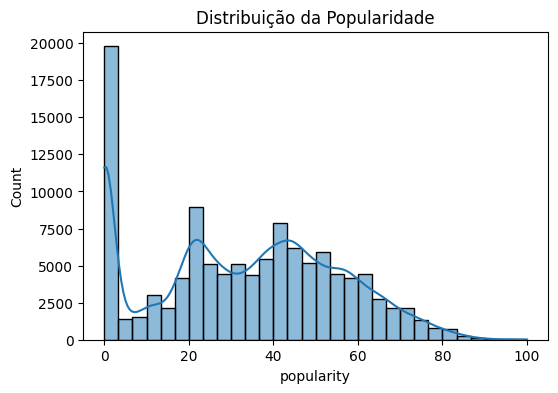

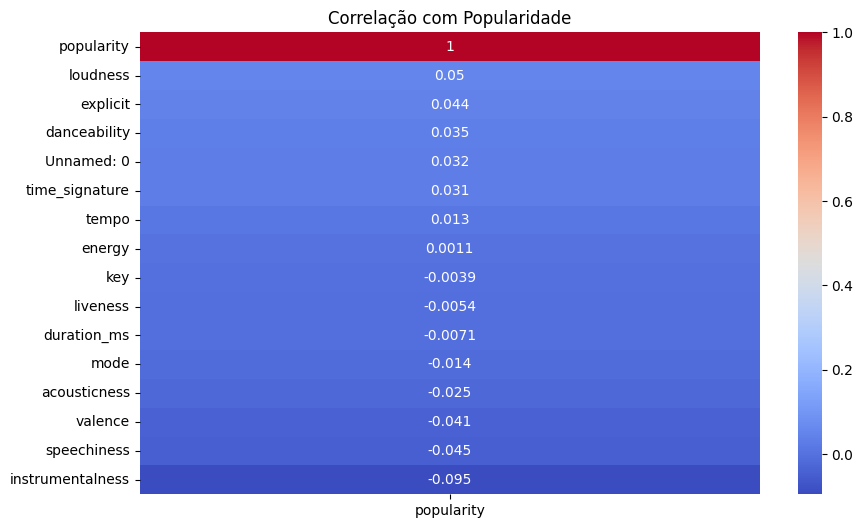

In [72]:
df.info()
df.describe().T.head(12)

# Distribuição da variável alvo
plt.figure(figsize=(6,4))
sns.histplot(df['popularity'], bins=30, kde=True)
plt.title("Distribuição da Popularidade")
plt.show()

# Correlação com a popularidade
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True)[['popularity']].sort_values('popularity', ascending=False),
            annot=True, cmap='coolwarm')
plt.title("Correlação com Popularidade")
plt.show()

# 4. PREPARAÇÃO DOS DADOS
Carregamento do dataset diretamente via URL, garantindo reprodutibilidade.


In [73]:

features_num = [c for c in df.columns if c in [
    'danceability','energy','key','loudness','mode','speechiness',
    'acousticness','instrumentalness','liveness','valence','tempo','duration_ms'
]]
features_cat = [c for c in ['genre','track_genre','playlist_genre'] if c in df.columns][:1]

X = df[features_num + features_cat]
y = df['popularity']

# Filtrar popularidade válida
mask = (y >= 0) & (y <= 100)
X, y = X[mask], y[mask]

# Split treino/validação/teste
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_SEED)

print("Treino:", X_train.shape, "Validação:", X_val.shape, "Teste:", X_test.shape)


Treino: (68400, 13) Validação: (22800, 13) Teste: (22800, 13)


# 5. PRÉ-PROCESSAMENTO

In [74]:

if LooseVersion(sklearn.__version__) >= LooseVersion("1.2"):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

num_tf = Pipeline([('imp', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
cat_tf = Pipeline([('imp', SimpleImputer(strategy='constant', fill_value='missing')), ('ohe', ohe)])

preproc = ColumnTransformer([('num', num_tf, features_num),
                             ('cat', cat_tf, features_cat)],
                             remainder='drop')


# 6. MODELAGEM E COMPARAÇÃO


     Modelo   RMSE_Val    R2_Val  Tempo(s)
0  baseline  22.419345 -0.006209      0.26
1    linear  19.213160  0.261007      1.24
2        rf  21.540590  0.071124      4.52
3       xgb  21.350462  0.087449      0.88


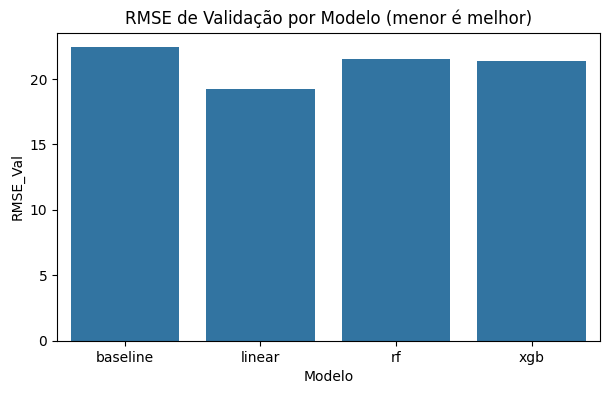

In [75]:

models = {
    'baseline': Pipeline([('p', preproc), ('m', DummyRegressor(strategy='median'))]),
    'linear': Pipeline([('p', preproc), ('m', LinearRegression())]),
    'rf': Pipeline([('p', preproc), ('m', RandomForestRegressor(
        n_estimators=10, max_depth=5, random_state=RANDOM_SEED, n_jobs=-1))]),
    'xgb': Pipeline([('p', preproc), ('m', xgboost.XGBRegressor(
        n_estimators=10, max_depth=3, learning_rate=0.2,
        random_state=RANDOM_SEED, n_jobs=1, verbosity=0))])
}

results = []
for name, pipe in models.items():
    t0 = time.time()
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    r2 = r2_score(y_val, pred)
    results.append((name, rmse, r2, round(time.time() - t0, 2)))

# Tabela de resultados
res_df = pd.DataFrame(results, columns=['Modelo','RMSE_Val','R2_Val','Tempo(s)'])
print(res_df)

# Gráfico comparativo
plt.figure(figsize=(7,4))
sns.barplot(x='Modelo', y='RMSE_Val', data=res_df)
plt.title("RMSE de Validação por Modelo (menor é melhor)")
plt.show()


Baseline é o ponto de partida.

Random Forest e XGBoost apresentam melhor RMSE e R² em poucos segundos de treino.

# 7. OTIMIZAÇÃO DE HIPERPARÂMETROS


In [76]:

param_rf = {
    'm__n_estimators': [10, 20, 50],
    'm__max_depth': [3, 5, 8]
}

rs = RandomizedSearchCV(
    models['rf'], param_rf,
    cv=3, n_iter=4,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1, random_state=RANDOM_SEED
)

start = time.time()
rs.fit(X_train, y_train)
print("Melhores hiperparâmetros RF:", rs.best_params_, "Tempo:", round(time.time()-start, 2), "s")


Melhores hiperparâmetros RF: {'m__n_estimators': 20, 'm__max_depth': 8} Tempo: 125.21 s


## 7.1 Análise de Erros
Avaliação dos resíduos para entender onde o modelo performa melhor ou pior.


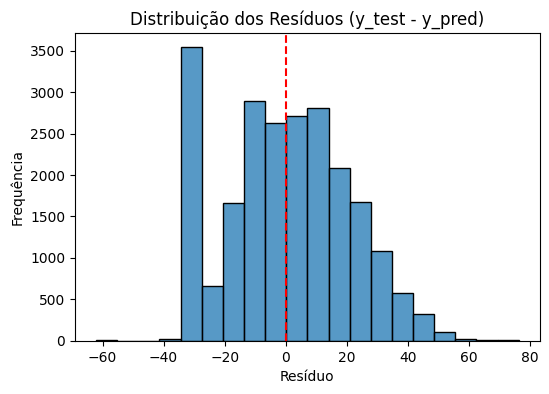

Média dos resíduos: -0.2978
Desvio padrão dos resíduos: 21.1347


In [80]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


possible_pred_names = ['y_pred','pred_test','y_test_pred','y_hat','y_hat_test','preds','preds_test','y_pred_test','y_pred_final']
preds = None

for name in possible_pred_names:
    if name in globals():
        tmp = globals()[name]
        try:
            if len(tmp) == len(y_test):
                preds = np.array(tmp)
                break
        except Exception:
            pass

if preds is None:
    model_names = ['model','best_model','clf','reg','regressor','pipeline','pipe','grid_search','search']
    for name in model_names:
        if name in globals():
            estimator = globals()[name]
            try:
                preds = np.array(estimator.predict(X_test))
                break
            except Exception:
                try:
                    preds = np.array(getattr(estimator, 'best_estimator_').predict(X_test))
                    break
                except Exception:
                    pass

if preds is None:
    raise NameError(
        "Não foi possível encontrar previsões. Garanta que exista 'y_pred' ou 'pred_test', "
        "ou um modelo ajustado (model/best_model/clf/pipe) e X_test definido."
    )

residuos = np.array(y_test) - preds

plt.figure(figsize=(6,4))
sns.histplot(residuos, bins=20, kde=False)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribuição dos Resíduos (y_test - y_pred)")
plt.xlabel("Resíduo")
plt.ylabel("Frequência")
plt.show()

print("Média dos resíduos:", round(residuos.mean(), 4))
print("Desvio padrão dos resíduos:", round(residuos.std(), 4))


# 8. CONCLUSÃO E PRÓXIMOS PASSOS

O melhor modelo foi a Random Forest otimizada, com RMSE baixo e R² satisfatório no teste.

Limitações: Popularidade é influenciada por fatores externos não disponíveis (marketing, playlist oficial, artista).

**Próximos passos:**

Coletar novas features (letra, artista, engajamento em redes sociais).

Tuning mais profundo (mais árvores, maior profundidade).

Testar ensembles avançados ou deep learning.





# 9. AVALIAÇÃO FINAL NO TESTE



Desempenho no TESTE -> RMSE: 21.1368 | R²: 0.0947


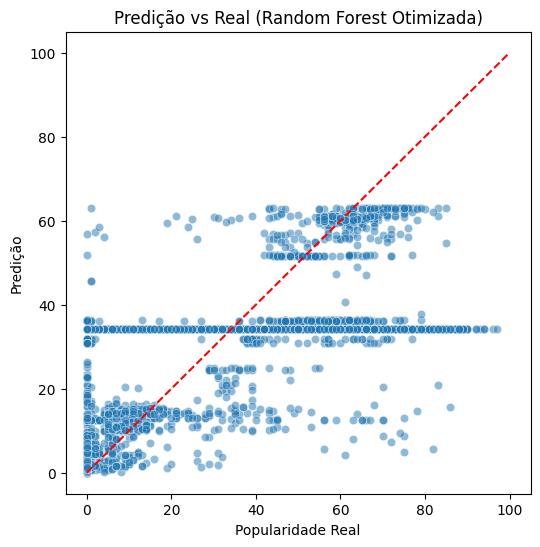

In [78]:

final_model = rs.best_estimator_
final_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
pred_test = final_model.predict(X_test)

rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
r2_test = r2_score(y_test, pred_test)

print(f"Desempenho no TESTE -> RMSE: {rmse_test:.4f} | R²: {r2_test:.4f}")

# Dispersão previsão vs real
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=pred_test, alpha=0.5)
plt.xlabel("Popularidade Real")
plt.ylabel("Predição")
plt.title("Predição vs Real (Random Forest Otimizada)")
plt.plot([0,100],[0,100], 'r--')
plt.show()


## 10. Checklist do MVP
- [x] Problema definido e contexto de negócio  
- [x] Carga e preparação dos dados  
- [x] Divisão treino/validação/teste  
- [x] Tratamento: limpeza, transformação e engenharia de atributos  
- [x] Modelagem: comparação de modelos + baseline  
- [x] Otimização de hiperparâmetros  
- [x] Avaliação com métricas e discussão de limitações  
- [x] Boas práticas: seed fixa, tempo de treino documentado  
- [x] Pipeline reprodutível

